In [49]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold


In [50]:

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# Concatenate (union) the dataframes
df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

print(df_All.head())


   425_pct_Al  M_Value  C4_pct_Eth  C4_pct_H2O  C4_pct_Hex  \
0    6.307630  3.50893    2.508420    21.96340    0.659256   
1    6.308335  3.50863    2.511135    21.96865    0.659930   
2    6.309390  3.50818    2.515210    21.97655    0.660942   
3    6.310090  3.50788    2.517925    21.98185    0.661616   
4    6.310790  3.50758    2.520640    21.98715    0.662291   

   HydWtr_pct_Ammonia  HydWtr_Na2O   DI55152   FC55003       FC55552  \
0            0.908765     2.712180  0.925255  4919.290  41564.100000   
1            0.907643     2.805415  0.924281  5039.445  41558.250000   
2            0.905959     2.945270  0.923773  5268.620  41524.066667   
3            0.904837     3.038505  0.924103  5349.320  41500.275000   
4            0.903715     3.131740  0.924258  5563.165  41466.625000   

       FC55569  FFC55553  FFC55555    LC55555   PI55004   TC55552     TC55555  \
0  6918.110000  0.996975  0.751501  59.968800  1.306310  177.1880  180.125000   
1  6919.960000  0.998847  0.7505

In [51]:
# selected_columns = ['Butanol', 
#                     'FC55569',
#                     'DI55152',
#                     '425 %Al',
#                     'TC55552',
#                     'FC55003',
#                     'LC55555',
#                     'FFC55553',
#                     'FFC55555',
#                     'TC55555',
#                     'TI55021',
#                     'PI55004',
#                     'FC55552'
#                     ]
# existing_columns = [col for col in selected_columns if col in df_All.columns]
# df_All = df_All[existing_columns]

print(df_All.head())

   425_pct_Al  M_Value  C4_pct_Eth  C4_pct_H2O  C4_pct_Hex  \
0    6.307630  3.50893    2.508420    21.96340    0.659256   
1    6.308335  3.50863    2.511135    21.96865    0.659930   
2    6.309390  3.50818    2.515210    21.97655    0.660942   
3    6.310090  3.50788    2.517925    21.98185    0.661616   
4    6.310790  3.50758    2.520640    21.98715    0.662291   

   HydWtr_pct_Ammonia  HydWtr_Na2O   DI55152   FC55003       FC55552  \
0            0.908765     2.712180  0.925255  4919.290  41564.100000   
1            0.907643     2.805415  0.924281  5039.445  41558.250000   
2            0.905959     2.945270  0.923773  5268.620  41524.066667   
3            0.904837     3.038505  0.924103  5349.320  41500.275000   
4            0.903715     3.131740  0.924258  5563.165  41466.625000   

       FC55569  FFC55553  FFC55555    LC55555   PI55004   TC55552     TC55555  \
0  6918.110000  0.996975  0.751501  59.968800  1.306310  177.1880  180.125000   
1  6919.960000  0.998847  0.7505

In [52]:
# List of columns to exclude to run XGboost feature selection
exclude_columns = [#'Date',
                 'C4_pct_Hex', 'HydWtr_Na2O',
                 'TC55555'  
                   ]

# Create a new DataFrame without the excluded columnsd
df_All = df_All.drop(columns=exclude_columns)

In [53]:
# Set max columns to display
pd.set_option('display.max_columns', None)

In [54]:
df_All.columns

Index(['425_pct_Al', 'M_Value', 'C4_pct_Eth', 'C4_pct_H2O',
       'HydWtr_pct_Ammonia', 'DI55152', 'FC55003', 'FC55552', 'FC55569',
       'FFC55553', 'FFC55555', 'LC55555', 'PI55004', 'TC55552', 'TI55021',
       'Butanol'],
      dtype='object')

In [55]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [56]:
# df_All.drop('Date', axis=1, inplace=True)

In [57]:
print(df_All.describe())

         425_pct_Al       M_Value    C4_pct_Eth    C4_pct_H2O  \
count  54701.000000  54701.000000  54701.000000  54701.000000   
mean       6.112584      3.604726      1.274754     20.756146   
std        0.316017      0.173736      0.677477      2.859486   
min        0.252306      1.461875      0.086948      7.932310   
25%        5.987750      3.506780      0.675285     18.331550   
50%        6.130470      3.595655      1.291115     20.731850   
75%        6.270075      3.696090      1.719630     22.989150   
max        8.020685      5.827565      8.711360     33.731050   

       HydWtr_pct_Ammonia       DI55152       FC55003       FC55552  \
count        54701.000000  54701.000000  54701.000000  54701.000000   
mean             0.969410      0.944165   5946.323971  36128.859598   
std              0.144668      0.042737    794.065219   4270.390546   
min              0.390025      0.815428   2991.532500  18800.350000   
25%              0.877716      0.915431   5446.200000  3499

In [58]:
# Assuming your data is in filtered_df and you want to predict 'target_column_name'
X = df_All.drop('Butanol', axis=1)  # Replace 'target_column_name' with your target column's name
y = df_All['Butanol']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate=0.03,
    n_estimators=600,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=2.0,
    alpha=0.2,
    reg_lambda=2,
    colsample_bylevel=0.8,
    colsample_bynode=0.7
)
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=0.8,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [59]:
# Predict on training data
y_train_pred = xgb_model.predict(X_train)
# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
# print(f"Mean Squared Error on Training Data: {mse_train}")
# Predict on the test set
y_pred = xgb_model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error on the Testing Data: {mse}")
#################################################################
rmse_train = np.sqrt(mse_train)
# print(f"Root Mean Squared Error on Training Data: {rmse_train}")
rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error on the Testing Data: {rmse}")
################################################################
# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
# print(f"R-squared value on Training Data: {r2_train:.2f}")
# Calculate R-squared
r2 = r2_score(y_test, y_pred)
# print(f"R-squared value on the Testing Data: {r2:.2f}")
################################################################
current_features = X.columns.tolist()
# Calculate Adjusted R-squared
def adjusted_r2(r2, n, k):
    """
    Compute the adjusted R^2 from R^2, number of samples (n) and number of predictors (k).
    
    Args:
    - r2 (float): R^2 value
    - n (int): number of samples
    - k (int): number of predictors

    Returns:
    - float: adjusted R^2 value
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)
adj_r2 = adjusted_r2(r2, len(y_test), len(current_features))
# print(f"Adjusted R^2 value: {adj_r2}")

# Predict and evaluate on training data
y_train_pred = xgb_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Predict and evaluate on test data
y_pred = xgb_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred)

# Calculate Adjusted R-squared for test data
current_features = X.columns.tolist()
n = len(y_test)
k = len(current_features)
adj_r2_test = 1 - (1 - r2_test) * (n - 1) / (n - k - 1)

# Organize metrics into a dictionary
performance_metrics = {
    'p_MSE Train': mse_train,
    'p_RMSE Train': rmse_train,
    'p_R2 Train': r2_train,
    'p_MSE Test': mse_test,
    'p_RMSE Test': rmse_test,
    'p_R2 Test': r2_test,
    'p_Adjusted R2 Test': adj_r2_test
}

# Convert dictionary to DataFrame
performance_df = pd.DataFrame([performance_metrics])

performance_df


,p_MSE Train,p_RMSE Train,p_R2 Train,p_MSE Test,p_RMSE Test,p_R2 Test,p_Adjusted R2 Test
0,7.935281,2.816963,0.908697,12.185697,3.490802,0.867723,0.867542


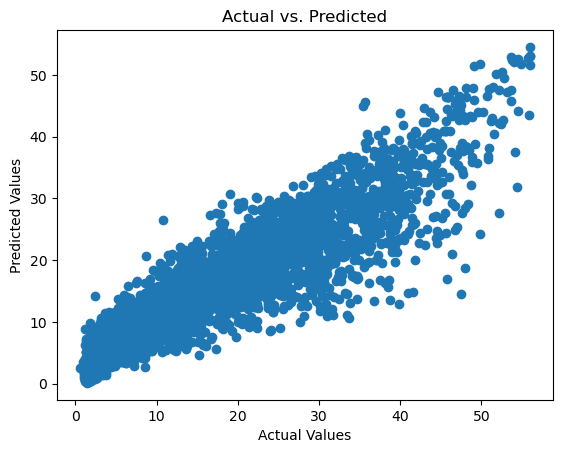

In [60]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()


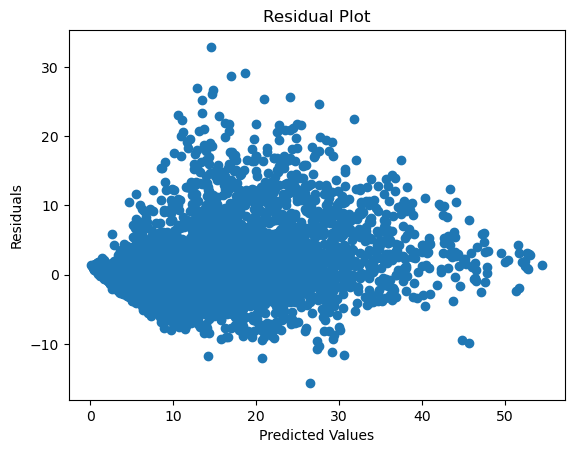

In [61]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [62]:
num_rows = df_All.shape[0]

splits = num_rows//10000

if splits < 5:
    splits = 5

In [63]:
# Define the K-fold cross validator
kfold = KFold(n_splits=splits, shuffle=True, random_state=42)

# Perform K-fold cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Take the square root of the scores to get the RMSE
rmse_scores = np.sqrt(-scores)

# Print out the results
print(f'Scores for each fold are: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard deviation of RMSE: {np.std(rmse_scores)}')

Scores for each fold are: [3.56810985 3.57910679 3.64140228 3.75449932 3.63116614]
Average RMSE: 3.634856878165619
Standard deviation of RMSE: 0.06623294631417725


In [64]:
df_All.columns

Index(['425_pct_Al', 'M_Value', 'C4_pct_Eth', 'C4_pct_H2O',
       'HydWtr_pct_Ammonia', 'DI55152', 'FC55003', 'FC55552', 'FC55569',
       'FFC55553', 'FFC55555', 'LC55555', 'PI55004', 'TC55552', 'TI55021',
       'Butanol'],
      dtype='object')